# NLP Standard Project 
Emotion Discovery and Reasoning its Flip in Conversation (EDiReF) - SemEval 2024 – Task 10 - Task C – EFR in English conversation:
Given a multiparty code-mixed conversation along with emotions for each utterance, the goal is to identify the trigger utterance for each emotionflip in the dialogue

In [66]:
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt

#modeling
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder

import torch

#metrics
from sklearn.metrics import classification_report

## Data Loading

Load the JSON in a Pandas Dataframe

In [23]:
file_path_train = 'Data/Task C/MELD_train_efr.json'

df_train = pd.read_json(file_path_train)

df_train.shape

(4000, 5)

In [24]:
df_train.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


Drop episode column since it is only an index and it is not useful for the task

In [25]:
df = df_train.drop(columns=['episode'])
print(f"Dataframe shape after dropping column: {df.shape}")
df.head()

Dataframe shape after dropping column: (4000, 4)


,speakers,emotions,utterances,triggers
0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


## Preprocessing

### NaN values
Some trigger labels are not correctly formatted and appear as NaN -> we convert them to zero to avoid errors.

In [26]:
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 9


In [27]:
df["triggers"] = df["triggers"].apply(lambda x: [0 if elem != 1 and elem != 0 else elem for elem in x])

In [28]:
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 0


### Split data 
80/10/10 train/val/test split

In [29]:
df_train, temp = train_test_split(df, test_size=0.2, shuffle=False)
df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3200, 4)
Test shape: (400, 4)
Val shape: (400, 4)


In [130]:
print(f"Dialogue in the last row of df_train: {df_train['utterances'][3199]}")

Dialogue in the last row of df_train: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.']


In [ ]:
print(f"Dialogue in the first row of df_test: {df_test['utterances'][3200]}")

Dialogue in the first row of df_test: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.', "I'm Ross!"]


In [ ]:
print(f"Il discorso continua fino all'utterance numero 3205")
print(f"Dialogue: {df_test['utterances'][3205]}")

il discorso continua fino all'utterance numero 3205
Dialogue: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.', "I'm Ross!", "I'm divorced, and I have a kid!", "I'm Joey! I'm an actor! I don't know squat about dinosaurs!", "I'm Ted, and I just moved here a month ago, and New York really scares me.", 'All right, there you go!', 'Yeah, you hang in there Teddy!', "I'm Andrew, and I didn't pay for this p

In [ ]:
print(f"Dialogue in the last row of df_test: {df_test['utterances'][3599]}")

Dialogue in the last row of df_test: ['Oh, that is so unfortunate.', 'What?', 'Cute naked guy is really starting to put on weight.', "Okay, I'll be back in just a minute. Oh, Phoebe I'm sorry that I left lipstick marks on the phone.", "You didn't leave lipstick marks on the phone.", "Oh, then it must've been you. Bye.", "Bye-bye!  That's why I moved out.", "Hey, y'know while we're on that, when are you gonna tell my sister that you don't live here anymore.", 'I think on some levels she already knows.']


In [ ]:
print(f"Dialogue in the first row of df_val: {df_val['utterances'][3600]}")

Dialogue in the first row of df_val: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?']


Effettivamente pare che il discorso venga splittato in due tra train e test però il prof specifica nelle raccomandazioni: "Given the dataset format, this property should be trivially guaranteed." 

Dal forum: "According to the instructions, you are free to perform data splitting as you prefer and motivate your decision accordingly.
In other words, there is no explicit penalization for data splitting.
Note that this doesn't mean that potential issues/consequences are evaluated equally.
Think about what you would do in a real-world scenario.
To sum up, we evaluate your understanding of the problem and your corresponding actions."

In [30]:
df_train = df.iloc[:3205,:]
temp = df.iloc[3205:,:]

df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3205, 4)
Test shape: (397, 4)
Val shape: (398, 4)


In [136]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][3601]}")

Dialouge in the last row of df_test: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.']


In [137]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][3602]}")

Dialouge in the first row of df_val: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.', "How would that go?  Well, it didn't rhyme, but I liked it."]


Ancora un dialogo splittato tra test e val

In [31]:
df_train = df.iloc[:3205,:]
df_test = df.iloc[3205:3603,:]
df_val = df.iloc[3603:,:]

In [140]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][3602]}")

Dialouge in the last row of df_test: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.', "How would that go?  Well, it didn't rhyme, but I liked it."]


In [141]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][3603]}")

Dialouge in the first row of df_val: ['Last stop, Montreal. This stop is Montreal.', 'What?', 'I made a bet with myself that you have beautiful eyes. Now that I see them, I win.', 'What?', "We're at my stop. But would you like to have coffee?", 'Are we really in Montreal?!', 'Yes we are. So, coffee?', 'Coffee sounds great.  Wait, so, so you live in Montreal?']


Questa dovrebbe essere la shape dei dataset

In [32]:
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3205, 4)
Test shape: (398, 4)
Val shape: (397, 4)


### Split every sentence in the dfs

In [58]:
def split_utterances(df):
    speakers_list = []
    utterances_list = []
    emotions_list = []
    trigger_list = []

    #Itera su ogni riga del dataframe originale
    for index, row in df.iterrows():
        speakers = row['speakers']
        utterances = row['utterances']
        emotions = row['emotions']
        triggers = row['triggers']
        
        # Itera su ogni frase nell'array 'utterances'
        for i in range(len(utterances)):
            speakers_list.append(speakers[i])
            utterances_list.append(utterances[i])
            emotions_list.append(emotions[i])
            trigger_list.append(triggers[i])
    
    # Crea un nuovo dataframe dalle liste
    new_df = pd.DataFrame({
        'speaker': speakers_list,
        'utterance': utterances_list,
        'emotion': emotions_list,
        'trigger': trigger_list
    })

    return new_df

In [69]:
df_train_s = split_utterances(df_train)
df_train_s.head(15)

,speaker,utterance,emotion,trigger
0,Chandler,also I was the point person on my company's tr...,neutral,0.0
1,The Interviewer,You must've had your hands full.,neutral,0.0
2,Chandler,That I did. That I did.,neutral,0.0
3,The Interviewer,So let's talk a little bit about your duties.,neutral,1.0
4,Chandler,My duties? All right.,surprise,0.0
5,Chandler,also I was the point person on my company's tr...,neutral,0.0
6,The Interviewer,You must've had your hands full.,neutral,0.0
7,Chandler,That I did. That I did.,neutral,0.0
8,The Interviewer,So let's talk a little bit about your duties.,neutral,0.0
9,Chandler,My duties? All right.,surprise,0.0


In [57]:
print(df_train_s.iloc[52:69,:])

     speaker                                          utterance   emotion  \
52  Chandler                                          Hey, Mon.   neutral   
53    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
54  Chandler                                         Do I ever.       joy   
55  Chandler                                          Hey, Mon.   neutral   
56    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
57  Chandler                                         Do I ever.       joy   
58    Monica           Chris says they're closing down the bar.   sadness   
59  Chandler                                          Hey, Mon.   neutral   
60    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
61  Chandler                                         Do I ever.       joy   
62    Monica           Chris says they're closing down the bar.   sadness   
63  Chandler                                            No way!  surprise   

Ho notato che i trigger sono a 1.0 nei vari dialoghi *non* nelle stesse frasi. Ad esempio la stessa frase in un dialogo diverso, ha un trigger diverso. Riga 53 e riga 56 hanno la stessa frase ed emozione ma trigger diverso. Stessa cosa frase 63 e 68. 

Comincio a pensare che in realtà bisogna passare tutto il df così come lo si legge dal json.

In [76]:
df_test_s = split_utterances(df_test)

df_val_s = split_utterances(df_val)

### Data distributions
Is the train dataset imbalanced? Verify emotions and triggers

#### Emotions distribution

In [39]:
emotions_counts = {}
for emotions in df_train['emotions']:
    for emotion in emotions:
        if emotion in emotions_counts:
            emotions_counts[emotion] += 1
        else:
            emotions_counts[emotion] = 1

print(emotions_counts)

{'neutral': 12264, 'surprise': 3777, 'fear': 922, 'sadness': 1934, 'joy': 5141, 'disgust': 816, 'anger': 3031}


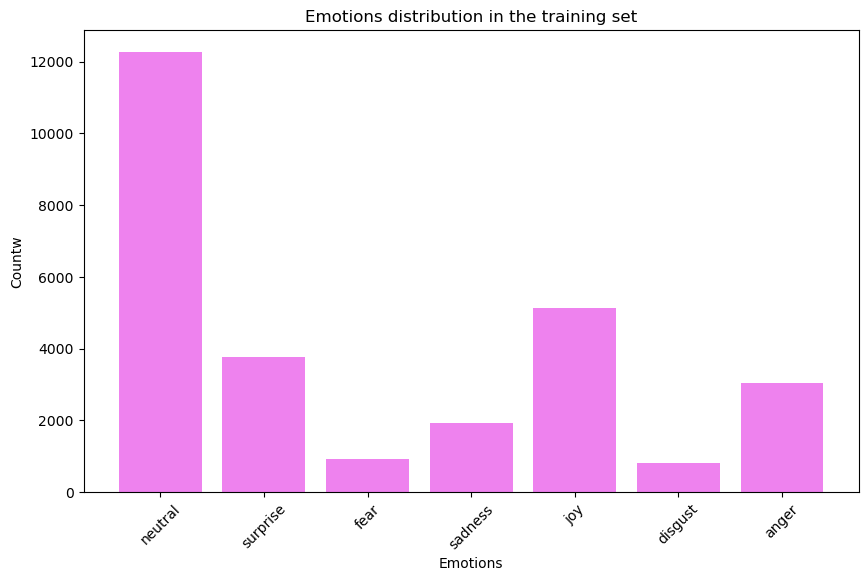

In [40]:
emotions = list(emotions_counts.keys())
emotion_counts = list(emotions_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(emotions, emotion_counts, color='violet')
plt.xlabel('Emotions')
plt.ylabel('Countw')
plt.title('Emotions distribution in the training set')
plt.xticks(rotation=45)
plt.show()

### Triggers distribution

In [67]:
triggers_counts= {}
for triggers in df_train['triggers']:
    for trigger in triggers:
        if trigger in triggers_counts:
            triggers_counts[trigger] += 1
        else:
            triggers_counts[trigger] = 1
print(triggers_counts)

{0.0: 23586, 1.0: 4299}


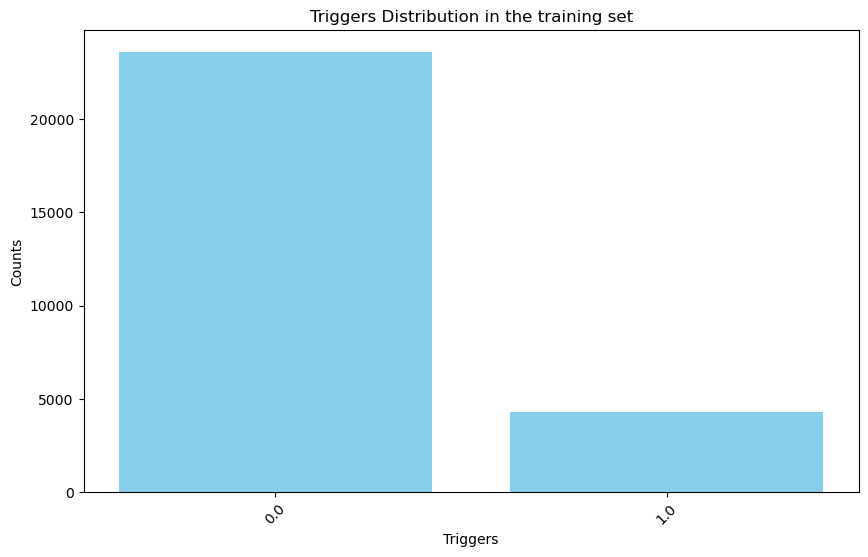

In [68]:
trigger = list(triggers_counts.keys())
trigger_counts = list(triggers_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(trigger, trigger_counts, color='skyblue')
plt.xlabel('Triggers')
plt.ylabel('Counts')
plt.title('Triggers Distribution in the training set')
plt.xticks(ticks=trigger, labels=['0.0', '1.0'], rotation=45)
plt.show()

As we can see both emotions and triggers are highly imbalanced, the emotion with the highest count is 'neutral' and the trigger with the highest count is '0.0'. 

When a class imbalance exists within the training data, machine learning models will typically over-classify the larger classes due to their increased prior probability. As a result, the instances belonging to the smaller class(es) are typically misclassified more often than those belonging to the larger class(es).

How to deal with imbalanced data in classification? https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

Class weights penso sia la strategia migliore da adottare per questo caso

In [69]:
# Calcola i pesi delle classi
total_samples = len(df_train)
class_weights = {emotion: total_samples / (len(emotions_counts) * count) for emotion, count in emotions_counts.items()}

print("Class weights:", class_weights)

Class weights: {'neutral': 0.03733342652129345, 'surprise': 0.12122243655206325, 'fear': 0.4965912612333437, 'sadness': 0.23674102526222485, 'joy': 0.08905993831105677, 'disgust': 0.5610994397759104, 'anger': 0.1510581137766885}


Class weights computing using sklearn class_weight='balanced'

In [77]:
all_emotions = [label for sublist in df_train['emotions'] for label in sublist]
train_emotions = np.array(all_emotions)
unique_emotions = np.unique(all_emotions)

#weights
emotion_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_emotions, y=train_emotions)

#save in dictionary
emotions_weights_dict = dict(zip(unique_emotions, emotion_weights))

print("Emotion class weights:", emotions_weights_dict)

Emotion class weights: {'anger': 1.3142762878823584, 'disgust': 4.881827731092437, 'fear': 4.320576386736907, 'joy': 0.7748631450245922, 'neutral': 0.3248182834777747, 'sadness': 2.059757719013148, 'surprise': 1.0546919323726314}


In [78]:
# Calcolo dei pesi per la colonna 'triggers'
all_triggers = [label for sublist in df_train['triggers'] for label in sublist]
train_triggers = np.array(all_triggers)
unique_triggers = np.unique(all_triggers)

trigger_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_triggers, y=train_triggers)
triggers_weights_dict = dict(zip(unique_triggers, trigger_weights))

print("Trigger class weights:", triggers_weights_dict)

Trigger class weights: {0.0: 0.5911345713558891, 1.0: 3.243196092114445}


## Models definition

You should train and evaluate a BERT baseline on two different settings:
     
     - Freezed: we freeze the BERT embedding layer weights and fine-tune the classifier heads on top
     - Full: we fine-tune the whole model architecture. 
     
Make sure you set a small enough batch size.  We recommend 1.

We recommend `bert-base-uncased`.

In addition, you should evaluate a random and a majority classifier for emotions and triggers.
You should report a comparison with your selected model(s) and the provided baselines

#### Baseline models 
Defining random and majority dummy classifiers 

In [60]:
random_emotions = DummyClassifier(strategy='uniform', random_state=42)
majority_emotions = DummyClassifier(strategy='most_frequent', random_state=42)

random_triggers = DummyClassifier(strategy='uniform', random_state=42)
majority_triggers = DummyClassifier(strategy='most_frequent', random_state=42)

## Evaluation Metrics

## Training and evaluation

### Fitting baseline models

Comincio a pensare che non è questo il modo di passare i dati al modello, ma forse sarebbe più utile splittare le utterances in un 
singola frase e avere una struttura: (speaker) frase emotion trigger 
speaker direi che è opzionale 

Magari facciamo entrambe e vediamo qual è la performance migliore?

Va ancora fatto l'encoding del dataset

In [78]:
df_train_s.head()

,speaker,utterance,emotion,trigger
0,Chandler,also I was the point person on my company's tr...,neutral,0.0
1,The Interviewer,You must've had your hands full.,neutral,0.0
2,Chandler,That I did. That I did.,neutral,0.0
3,The Interviewer,So let's talk a little bit about your duties.,neutral,1.0
4,Chandler,My duties? All right.,surprise,0.0


In [80]:
X_train = df_train_s.drop(columns=['emotion', 'trigger'])

y_train_emotions = df_train_s['emotion']
y_train_triggers = df_train_s['trigger']

In [84]:
X_test = df_test_s.drop(columns=['emotion', 'trigger'])

y_test_emotions = df_test_s['emotion']
y_test_triggers = df_test_s['trigger']

Encoding

ho fatto il OneHot Encoding perchè abbiamo a che fare con variabili categoriali nominali che non hanno quindi un ordine intrinseco.

In [106]:
oh_encoder = OneHotEncoder()

#train
X_train_encoded = oh_encoder.fit_transform(X_train).toarray()
y_train_emotions_encoded = oh_encoder.fit_transform(y_train_emotions.values.reshape(-1, 1)).toarray()
# Get the emotions ordered
categories = oh_encoder.categories_[0]
emotion_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

y_train_triggers_encoded = oh_encoder.fit_transform(y_train_triggers.values.reshape(-1, 1)).toarray()
#get the triggers ordered
categories = oh_encoder.categories_[0]
trigger_names = ['0.0', '1.0']

#test
X_test_encoded = oh_encoder.fit_transform(X_test).toarray()
y_test_emotions_encoded = oh_encoder.fit_transform(y_test_emotions.values.reshape(-1, 1)).toarray()
y_test_triggers_encoded = oh_encoder.fit_transform(y_test_triggers.values.reshape(-1, 1)).toarray()

In [107]:
random_emotions.fit(X_train_encoded, y_train_emotions_encoded)
majority_emotions.fit(X_train_encoded, y_train_emotions_encoded)

random_triggers.fit(X_train_encoded, y_train_triggers_encoded)
majority_triggers.fit(X_train_encoded, y_train_triggers_encoded)

DummyClassifier(random_state=42, strategy='most_frequent')

### Evaluating baseline models

In [108]:
y_pred_random_emotions = random_emotions.predict(X_test_encoded)
y_pred_majority_emotions = majority_emotions.predict(X_test_encoded)

y_pred_random_triggers = random_triggers.predict(X_test_encoded)
y_pred_majority_triggers = majority_triggers.predict(X_test_encoded)

In [111]:
#Classification reports 

#emotions
print("Classification report for baseline random clf emotions:")
print(classification_report(y_test_emotions_encoded, y_pred_random_emotions, target_names=emotion_names, zero_division=0))

print("Classification report for baseline majority clf emotions:")
print(classification_report(y_test_emotions_encoded, y_pred_majority_emotions, target_names=emotion_names, zero_division=0))

#triggers
print("Classification report for baseline random clf triggers:")
print(classification_report(y_test_triggers_encoded, y_pred_random_triggers, target_names=trigger_names, zero_division=0))

print("Classification report for baseline majority clf triggers:")
print(classification_report(y_test_triggers_encoded, y_pred_majority_triggers, target_names=trigger_names, zero_division=0))

Classification report for baseline random clf emotions:
              precision    recall  f1-score   support

       anger       0.12      0.48      0.20       455
     disgust       0.03      0.53      0.05        88
        fear       0.03      0.48      0.06       121
         joy       0.16      0.49      0.24       576
     neutral       0.42      0.47      0.44      1505
     sadness       0.08      0.43      0.14       349
    surprise       0.13      0.53      0.21       439

   micro avg       0.14      0.48      0.21      3533
   macro avg       0.14      0.49      0.19      3533
weighted avg       0.25      0.48      0.30      3533
 samples avg       0.14      0.48      0.21      3533

Classification report for baseline majority clf emotions:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       455
     disgust       0.00      0.00      0.00        88
        fear       0.00      0.00      0.00       121
         joy      

A quanto pare ci sono campioni senza etichette previste 

In [110]:
# Supponiamo che 'y_test_emotions_encoded' e 'y_pred_random_emotions' siano le etichette reali e previste

# Trova i campioni senza etichette previste per le emozioni (random clf)
no_predicted_labels_indices_random_emotions = np.where(np.all(y_pred_random_emotions == 0, axis=1))[0]
print("Campioni senza etichette previste (random clf emotions):", no_predicted_labels_indices_random_emotions)

# Trova i campioni senza etichette previste per le emozioni (majority clf)
no_predicted_labels_indices_majority_emotions = np.where(np.all(y_pred_majority_emotions == 0, axis=1))[0]
print("Campioni senza etichette previste (majority clf emotions):", no_predicted_labels_indices_majority_emotions)

# Trova i campioni senza etichette previste per i triggers (random clf)
no_predicted_labels_indices_random_triggers = np.where(np.all(y_pred_random_triggers == 0, axis=1))[0]
print("Campioni senza etichette previste (random clf triggers):", no_predicted_labels_indices_random_triggers)

# Trova i campioni senza etichette previste per i triggers (majority clf)
no_predicted_labels_indices_majority_triggers = np.where(np.all(y_pred_majority_triggers == 0, axis=1))[0]
print("Campioni senza etichette previste (majority clf triggers):", no_predicted_labels_indices_majority_triggers)


Campioni senza etichette previste (random clf emotions): [ 425  455  802  840 1114 1155 1272 1498 1655 1829 1927 1983 2030 2101
 2325 2424 2475 2502 2837 3032 3102 3182 3302]
Campioni senza etichette previste (majority clf emotions): [   0    1    2 ... 3530 3531 3532]
Campioni senza etichette previste (random clf triggers): [   2    3    4    6   11   12   13   15   19   31   37   40   41   47
   52   57   58   59   60   61   62   64   67   72   78   80   82   85
   99  109  114  116  123  131  133  139  141  145  146  147  153  167
  171  172  176  178  179  181  187  188  191  199  200  203  205  209
  210  211  212  215  217  219  220  226  229  241  243  244  248  253
  254  256  259  260  263  278  283  285  286  287  290  291  301  305
  316  318  326  342  344  346  349  355  358  364  365  368  374  379
  386  387  388  390  394  399  413  414  415  416  423  425  430  439
  440  442  445  448  454  455  458  468  470  478  484  488  492  494
  498  501  502  512  525  526  53

Potrebbe essere dato dal fatto che i dati sono sbilanciati

random uniform e majority classifier non riescono a tenere conto delle class weights però si potrebbero fare dei random uniform e majority classifier custom che ne tengano conto.